# LeakyReLU (CNN & Object Detection) — Uçtan Uca Notlar

Bu defter, **LeakyReLU’nun ne olduğunu** en temelden başlayıp pratikte **CNN ve object detection** tarafında doğru yerde nasıl kullanılacağını anlatır.  
Kod örnekleri **minimal** tutulmuştur. Matematiğe **bilerek girmiyoruz** (ayrı bir defterde).

> Hedef: “Ne zaman LeakyReLU?”, “Neyi çözüyor?”, “Nerede kullanmak mantıklı?”, “Ne zaman kullanmamak lazım?”

## 1) ReLU’yu hatırlayalım (çok kısa)

ReLU, en yaygın aktivasyonlardan biridir:

- Pozitif bölgede: çıktıyı olduğu gibi geçirir  
- Negatif bölgede: çıktıyı **0** yapar

ReLU pratikte hızlıdır, stabildir ve CNN’lerde çok iyi çalışır.  
Ama ReLU’nun klasik bir problemi var 👇

## 2) ReLU’nun problemi: “Dying ReLU”

ReLU, negatif bölgede çıktıyı 0’a sabitlediği için bazı nöronlar **uzun süre** negatif tarafta kalabilir.  
Bu durumda:

- Aktivasyon hep 0 olur
- Gradien akışı azalır
- Bazı kanallar “ölü” gibi davranır (özellikle kötü init, yüksek LR, dengesiz dağılım gibi durumlarda)

Bu problem her modelde patlamaz; ama özellikle:
- Derin ağlar
- Sert öğrenme oranı
- Dağılım kaymaları (domain shift)
- Bazı blok tasarımları  
gibi senaryolarda daha çok görülür.

## 3) LeakyReLU fikri: “Negatif tarafta da küçük bir yol bırak”

LeakyReLU, ReLU’ya çok benzer ama **negatif tarafta** çıktıyı tamamen 0 yapmaz.  
Negatif tarafta küçük bir **sızıntı (leak)** bırakır:

- Pozitif: aynı (lineer geçiş)
- Negatif: küçük bir çarpanla geçiş (ör. 0.01)

**Sonuç:** Negatif bölgede gradient tamamen “ölmez”.  
Bu da “dying ReLU” riskini düşürür.

In [1]:
import torch
import torch.nn as nn

relu = nn.ReLU()
lrelu = nn.LeakyReLU(negative_slope=0.01)  # defaulta yakın bir ayar

x = torch.tensor([-3.0, -1.0, 0.0, 1.0, 3.0])
print("x      :", x.tolist())
print("ReLU   :", relu(x).tolist())
print("LeakyReLU:", lrelu(x).tolist())

x      : [-3.0, -1.0, 0.0, 1.0, 3.0]
ReLU   : [0.0, 0.0, 0.0, 1.0, 3.0]
LeakyReLU: [-0.029999999329447746, -0.009999999776482582, 0.0, 1.0, 3.0]


## 4) “negative_slope” (α) nasıl düşünülür?

LeakyReLU’nun temel ayarı **negative_slope** (bazı kaynaklarda α) değeridir.

- Küçük değer (örn 0.01): ReLU’ya yakın davranır, sadece negatifte “çok az” geçiş verir
- Daha büyük değer (örn 0.1): negatif tarafta daha agresif geçiş sağlar

Pratikte:
- **0.01** ve **0.1** en sık görülen aralıktır
- Object detection modellerinde LeakyReLU görece daha yaygın olduğundan (özellikle YOLO ailesinin eski sürümlerinde) 0.1 da sık görülür

> Not: “En iyi α” diye evrensel bir sabit yoktur. Model, veri, LR ve normalizasyon seçimi ile değişir.

## 5) LeakyReLU vs PReLU (kısa net fark)

- **LeakyReLU:** negatif eğim sabittir (sen seçersin)
- **PReLU:** negatif eğim öğrenilir (parametre ekler)

Ne zaman hangisi?
- “Basit ve stabil”: LeakyReLU
- “Daha esnek ve kapasite istiyorum”: PReLU (ama overfit riski + parametre artışı)

Bu defterin odağı LeakyReLU olduğu için PReLU detayına girmiyoruz.

## 6) CNN ve Detection’da nerede kullanılır?

### Backbone (özellik çıkarıcı)
LeakyReLU backbone’da çalışır. Özellikle:
- Derinlik arttıkça “ölme” riskini azaltması
- Ucuz olması (Mish/Swish gibi pahalı değil)

### Neck (FPN / PAN / BiFPN vb.)
Neck’te de sorunsuz çalışır.  
Ama modern YOLO ekosisteminde **SiLU** çok yaygın olduğu için sıklıkla SiLU tercih edilir.

### Head (sınıflandırma / bbox reg)
Head’de de çalışır.  
Özellikle “hız+stabilite” isteyen yerlerde mantıklı.

**Kısa pratik kural:**
- “Hız + sağlamlık” istiyorsan: LeakyReLU
- “Biraz daha performans, modern baseline” istiyorsan: SiLU

## 7) Normalizasyon ile etkileşim (BatchNorm / GroupNorm)

LeakyReLU tek başına değil, genellikle **Conv + Norm + Act** kalıbı içinde kullanılır.

- BatchNorm (BN) ile genelde uyumlu
- GroupNorm (GN) ile de uyumlu

Bazı durumlarda “dying ReLU” zaten BN ile azaldığı için LeakyReLU farkı küçük olabilir.  
Ama yine de:
- küçük batch
- domain shift
- agresif LR  
gibi senaryolarda LeakyReLU fayda sağlayabilir.

## 8) “Gerçekten dying ReLU yaşıyor muyum?” hızlı kontrol

Şunları gözlüyorsan LeakyReLU denemek mantıklı:
- Eğitim sırasında bazı katmanlarda aktivasyonların büyük kısmı sürekli 0
- Loss düşmüyor / çok düzensiz
- Grad normları bazı bloklarda sürekli çok düşük
- LR artırınca model “kitleniyor” veya diverge ediyor

Aşağıdaki mini örnek sadece fikri göstermeye yarar (gerçek modelde daha karmaşık).

In [2]:
import torch
import torch.nn as nn

# Basit bir "tek katman + aktivasyon" senaryosu: gradient akışını gözlemek için
x = torch.linspace(-3, 3, steps=7, requires_grad=True)

relu = nn.ReLU()
lrelu = nn.LeakyReLU(0.01)

y_relu = relu(x).sum()
y_lrelu = lrelu(x).sum()

y_relu.backward(retain_graph=True)
grad_relu = x.grad.detach().clone()
x.grad.zero_()

y_lrelu.backward()
grad_lrelu = x.grad.detach().clone()

print("x        :", x.detach().tolist())
print("grad ReLU:", grad_relu.tolist())
print("grad LReLU:", grad_lrelu.tolist())

x        : [-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0]
grad ReLU: [0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0]
grad LReLU: [0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 0.009999999776482582, 1.0, 1.0, 1.0]


## 9) PyTorch’ta pratik kullanım

### Modül olarak
```python
nn.LeakyReLU(negative_slope=0.01, inplace=True)
```

### Functional olarak
```python
import torch.nn.functional as F
F.leaky_relu(x, negative_slope=0.01, inplace=True)
```

CNN bloklarında yaygın pattern:
**Conv → Norm → LeakyReLU**

In [3]:
import torch
import torch.nn as nn

class ConvNormAct(nn.Module):
    def __init__(self, cin, cout, k=3, s=1, p=1, negative_slope=0.01):
        super().__init__()
        self.conv = nn.Conv2d(cin, cout, k, stride=s, padding=p, bias=False)
        self.norm = nn.BatchNorm2d(cout)  # istersen GroupNorm da koyarsın
        self.act  = nn.LeakyReLU(negative_slope=negative_slope, inplace=True)

    def forward(self, x):
        return self.act(self.norm(self.conv(x)))

# mini test
x = torch.randn(2, 16, 32, 32)
block = ConvNormAct(16, 32, negative_slope=0.1)
y = block(x)
print(y.shape)

torch.Size([2, 32, 32, 32])


## 10) Detection tarafında “hangi slope” daha mantıklı?

Pratik rehber:
- **0.01**: güvenli default (ReLU’ya daha yakın)
- **0.1**: detection’da sık kullanılan agresif seçenek (özellikle eski YOLO pratiklerinde)

Ne seçileceği çoğu zaman:
- veri seti (özellikle low-light / noisy gibi)
- normalizasyon tipi
- LR ve optimizer ayarları
- backbone derinliği  
ile birlikte karar verilir.

> Bu yüzden en doğru yaklaşım: küçük bir **ablation** (tek parametre değiştir) ve mAP/FPS’e bak.

## 11) Ne zaman LeakyReLU kullanmamak daha mantıklı?

- Mobil/edge modellerde, ekosistem HardSwish üzerine kuruluysa (MobileNetV3 benzeri)
- Modern YOLO türevinde zaten SiLU ile oturmuş bir baseline varsa ve hız/accuracy dengesi iyi ise
- Quantization pipeline’ın spesifik bir aktivasyon beklentisi varsa

Buna rağmen LeakyReLU çoğu yerde “çalışır”; konu daha çok **tercih ve hedef metrik** meselesidir.

## 12) Mini kontrol listesi ✅

LeakyReLU eklerken:
- [ ] slope değerini belirle (0.01 veya 0.1 ile başla)
- [ ] Conv → Norm → Act düzenini koru
- [ ] inplace=True (uygunsa) kullan
- [ ] Ablation yap: *aynı model, sadece aktivasyon değişsin*
- [ ] mAP + latency + stability (loss eğrisi) birlikte değerlendir

Bu kadar. Matematik kısmını ayrı bir defterde ele alacağız.

## Ek: Küçük görselleştirme (isteğe bağlı)

Bu hücre aktivasyon eğrilerini görsel olarak karşılaştırır.  
Renk/tema ayarlamıyoruz; matplotlib default kullanır.

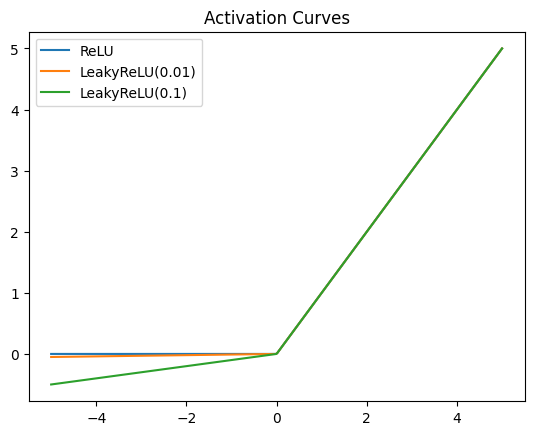

In [4]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

x = torch.linspace(-5, 5, 400)
relu = nn.ReLU()
lrelu_001 = nn.LeakyReLU(0.01)
lrelu_01  = nn.LeakyReLU(0.1)

plt.figure()
plt.plot(x.numpy(), relu(x).numpy(), label="ReLU")
plt.plot(x.numpy(), lrelu_001(x).numpy(), label="LeakyReLU(0.01)")
plt.plot(x.numpy(), lrelu_01(x).numpy(), label="LeakyReLU(0.1)")
plt.title("Activation Curves")
plt.legend()
plt.show()